In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from __future__ import print_function

from keras.models import Model
from keras.layers import Input, LSTM, Dense
from keras.optimizers import Adam
import numpy as np
import keras.backend as K
from pathlib import Path
import tensorflow as tf

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [4]:
raw_path = Path('../../data/raw/')
math_data = raw_path/'v1.0'

In [5]:
!ls '{math_data}'

extrapolate  interpolate  train-easy  train-hard  train-medium


In [6]:
train_easy_data = math_data/'train-easy'
train_easy_sample = train_easy_data/'algebra__linear_1d.txt'

In [7]:
datasets = !ls '{train_easy_data}'
len(datasets)

56

In [8]:
batch_size = 1024  # Batch size for training.
epochs = 75  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
data_path = train_easy_sample

In [9]:
with open(str(data_path), 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')

In [10]:
print(lines[1::2][:10])

['-3', '-1', '-8', '-4', '-4', '7', '1', '-1', '2', '-3']


In [11]:
# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
with open(str(data_path), 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')[:-1]

input_texts = lines[0::2]
target_texts = ['\t' + target_text + '\n' for target_text in lines[1::2]]

input_characters = set("".join(input_texts))
target_characters = set("".join(target_texts))

In [12]:
target_texts[-1]

'\t5\n'

In [13]:
input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

Number of samples: 666666
Number of unique input tokens: 43
Number of unique output tokens: 13
Max sequence length for inputs: 41
Max sequence length for outputs: 5


In [14]:
input_token_index = dict(
    [(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict(
    [(char, i) for i, char in enumerate(target_characters)])

In [15]:
target_token_index

{'\t': 0,
 '\n': 1,
 '-': 2,
 '0': 3,
 '1': 4,
 '2': 5,
 '3': 6,
 '4': 7,
 '5': 8,
 '6': 9,
 '7': 10,
 '8': 11,
 '9': 12}

In [16]:
def exact_match_metric(y_true, y_pred):
    
    # get indices from vectors 
    y_pred_argmax = tf.argmax(y_pred, axis=-1)
    y_true_argmax = tf.argmax(y_true, axis=-1)
    
    # get mask of rows with no entry
    mask = tf.equal(tf.reduce_sum(y_true, axis=-1),0)

    pred_match = tf.equal(y_pred_argmax, y_true_argmax)  
    
    # if no label in y_true, then actual match doesn't matter --> equal=True
    pred_match_fixed = tf.where(mask, tf.ones_like(pred_match, dtype=tf.bool), pred_match)

    exact_match = tf.reduce_min(tf.to_float(pred_match_fixed), axis=[1])
    return tf.reduce_mean(exact_match)

In [17]:
encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.

In [18]:
decoder_target_data[0]

array([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
      dtype=float32)

In [19]:
input_token_index = dict(
    [(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict(
    [(char, i) for i, char in enumerate(target_characters)])

In [20]:
encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

In [21]:
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.

In [ ]:
# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [22]:
# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Run training
adam = Adam(lr=6e-4, beta_1=0.9, beta_2=0.995, epsilon=1e-9, decay=0.0, amsgrad=False)

model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=[exact_match_metric])
trian_hist = model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
                       batch_size=batch_size,
                       epochs=epochs,
                       validation_split=0.2
                       )
# Save model
model.save('simple-lstm-2.h5')

Train on 533332 samples, validate on 133334 samples
Epoch 1/75
533332/533332 [==============================] - 39s 73us/step - loss: 0.6248 - exact_match_metric: 0.0520 - val_loss: 0.5752 - val_exact_match_metric: 0.0739
Epoch 2/75
533332/533332 [==============================] - 38s 71us/step - loss: 0.5573 - exact_match_metric: 0.0907 - val_loss: 0.5301 - val_exact_match_metric: 0.1210
Epoch 3/75
533332/533332 [==============================] - 38s 71us/step - loss: 0.5149 - exact_match_metric: 0.1459 - val_loss: 0.5000 - val_exact_match_metric: 0.1687
Epoch 4/75
533332/533332 [==============================] - 38s 72us/step - loss: 0.4828 - exact_match_metric: 0.1860 - val_loss: 0.4692 - val_exact_match_metric: 0.1995
Epoch 5/75
533332/533332 [==============================] - 38s 71us/step - loss: 0.4550 - exact_match_metric: 0.2119 - val_loss: 0.4410 - val_exact_match_metric: 0.2270
Epoch 6/75
533332/533332 [==============================] - 38s 72us/step - loss: 0.4242 - exact_m

/usr/local/lib/python3.5/dist-packages/keras/engine/network.py:877: UserWarning: Layer lstm_2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'lstm_1/while/Exit_2:0' shape=(?, 256) dtype=float32>, <tf.Tensor 'lstm_1/while/Exit_3:0' shape=(?, 256) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


In [23]:
# Next: inference mode (sampling).
# Here's the drill:
# 1) encode input and retrieve initial decoder state
# 2) run one step of decoder with this initial state
# and a "start of sequence" token as target.
# Output will be the next target token
# 3) Repeat with the current target token and current states

# Define sampling models
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())


def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence

In [24]:
for seq_index in range(100):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)

-
Input sentence: Solve 0 = 4*b + b + 15 for b.
Decoded sentence: -3

-
Input sentence: Solve -3*d = -0*d + 3 for d.
Decoded sentence: -1

-
Input sentence: Solve -4*h + 9 = 41 for h.
Decoded sentence: -8

-
Input sentence: Solve 2514*m = 2508*m - 24 for m.
Decoded sentence: -6

-
Input sentence: Solve -7*a + 6*a = 4 for a.
Decoded sentence: -4

-
Input sentence: Solve 288*w - 298*w = -70 for w.
Decoded sentence: 7

-
Input sentence: Solve -14*h = -4*h - 10 for h.
Decoded sentence: 1

-
Input sentence: Solve 5*w + 3 = -2 for w.
Decoded sentence: -1

-
Input sentence: Solve -15*f + 21*f - 12 = 0 for f.
Decoded sentence: 2

-
Input sentence: Solve -22 = 6*c - 4 for c.
Decoded sentence: -3

-
Input sentence: Solve 13*z - 7*z + 30 = 0 for z.
Decoded sentence: -5

-
Input sentence: Solve -4*v + 224 = -32*v for v.
Decoded sentence: -8

-
Input sentence: Solve 0 = -4*j - 906 + 894 for j.
Decoded sentence: -5

-
Input sentence: Solve -70*n - 222 = -107*n for n.
Decoded sentence: 6

-
Input sen

In [26]:
import matplotlib.pyplot as plt

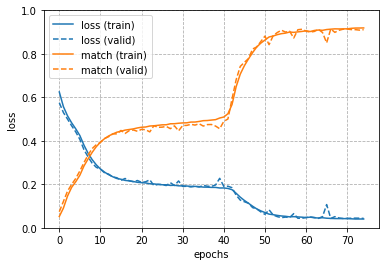

In [30]:
plt.plot(trian_hist.history['loss'], color='C0', label='loss (train)')
plt.plot(trian_hist.history['val_loss'], color='C0', label='loss (valid)', linestyle='--')
plt.plot(trian_hist.history['exact_match_metric'], color='C1', label='match (train)')
plt.plot(trian_hist.history['val_exact_match_metric'], color='C1', label='match (valid)', linestyle='--')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(loc='best')
plt.ylim([0,1])
plt.grid(True, linestyle='--')

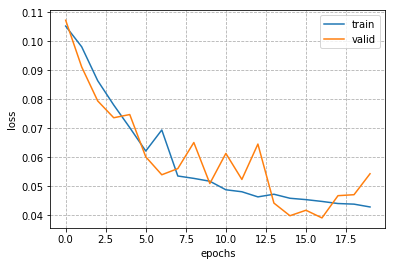

In [31]:
plt.plot(trian_hist.history['loss'], label='train')
plt.plot(trian_hist.history['val_loss'], label='valid')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(loc='best')
plt.grid(True, linestyle='--')

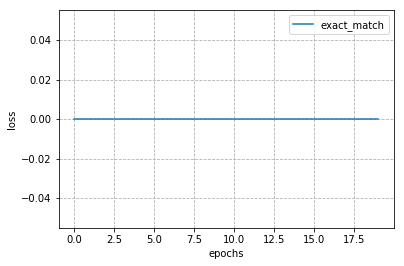

In [32]:
plt.plot(trian_hist.history['exact_match_metric'], label='exact_match')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(loc='best')
plt.grid(True, linestyle='--')

In [33]:
y_pred = model.predict_on_batch([encoder_input_data[:1024], decoder_input_data[:1024]])

In [34]:
np.shape(y_pred)

(1024, 5, 13)

In [35]:
target = decoder_target_data[:1024]

In [36]:
np.shape(target)

(1024, 5, 13)

In [41]:
argmax_pred = np.argmax(y_pred, axis=-1); argmax_pred

array([[ 2,  6,  1,  1,  1],
       [ 2,  4,  1,  1,  1],
       [ 2, 11,  1,  1,  1],
       ...,
       [ 2,  7,  1,  1,  1],
       [ 6,  1,  1,  1,  1],
       [10,  1,  1,  1,  1]])

In [44]:
max_pred = np.max(y_pred, axis=-1); max_pred

array([[0.9998703 , 0.99995303, 1.        , 0.99999046, 0.9999987 ],
       [0.9991985 , 0.9999949 , 1.        , 0.9999999 , 1.        ],
       [0.9997366 , 0.986476  , 1.        , 0.99978286, 0.9999335 ],
       ...,
       [0.99999976, 0.99999917, 1.        , 0.98244196, 0.99129385],
       [0.99998057, 1.        , 0.99999833, 0.9999999 , 0.99999964],
       [0.408946  , 1.        , 0.9999989 , 0.9999999 , 1.        ]],
      dtype=float32)

In [42]:
argmax_targ = np.argmax(target, axis=-1); argmax_targ

array([[ 2,  6,  1,  0,  0],
       [ 2,  4,  1,  0,  0],
       [ 2, 11,  1,  0,  0],
       ...,
       [ 2,  7,  1,  0,  0],
       [ 6,  1,  0,  0,  0],
       [10,  1,  0,  0,  0]])

In [39]:
matching_batches = np.min(np.equal(argmax_pred, argmax_targ),axis=-1)

In [40]:
np.sum(matching_batches)

0

In [103]:
input_tensor_1 = tf.placeholder('float', shape=[None, 3, 2])
input_tensor_2 = tf.placeholder('float', shape=[None, 3, 2])

results= exact_match_metric(input_tensor_1, input_tensor_2)

In [105]:
tensor_1 = np.array([[[1,0],[0,1],[1,0]]])
tensor_2 = np.array([[[1,0],[0,1],[2,1.1]]])

with tf.Session() as sess:
    res = sess.run([results], feed_dict={input_tensor_1: tensor_1,
                                         input_tensor_2: tensor_2})
print(res)

[1.0]


In [85]:
res

[1.0]

In [60]:
np.sum(tensor_1, axis=-1)

array([[1, 1, 1]])

In [61]:
np.sum(tensor_2, axis=-1)

array([[1, 1, 0]])

In [ ]:
print(1)

In [21]:
tf.__version__

'1.5.0'

In [31]:
from lstm import LSTM_S2S

In [32]:
lstm = LSTM_S2S(num_encoder_tokens, num_decoder_tokens, latent_dim)

In [33]:
model = lstm.get_model()

In [34]:
adam = Adam(lr=6e-4, beta_1=0.9, beta_2=0.995, epsilon=1e-9, decay=0.0, amsgrad=False)

model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=[exact_match_metric])
trian_hist = model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
                       batch_size=batch_size,
                       epochs=1,
                       validation_split=0.2
                       )

Train on 533332 samples, validate on 133334 samples
Epoch 1/1
533332/533332 [==============================] - 80s 150us/step - loss: 0.6207 - exact_match_metric: 0.0534 - val_loss: 0.5724 - val_exact_match_metric: 0.0740


In [35]:
input_samples = [encoder_input_data[seq_index: seq_index + 1] for seq_index in range(10)]
input_

outputs = lstm.decode_sample(input_samples,target_token_index, max_decoder_seq_length)

In [37]:
for i,o in zip(input_texts[:10], outputs):
    print(i)
    print(o)

Solve 0 = 4*b + b + 15 for b.
-1

Solve -3*d = -0*d + 3 for d.
-1

Solve -4*h + 9 = 41 for h.
-1

Solve 2514*m = 2508*m - 24 for m.
-1

Solve -7*a + 6*a = 4 for a.
-1

Solve 288*w - 298*w = -70 for w.
-1

Solve -14*h = -4*h - 10 for h.
-1

Solve 5*w + 3 = -2 for w.
-1

Solve -15*f + 21*f - 12 = 0 for f.
-1

Solve -22 = 6*c - 4 for c.
-1



In [38]:
def exact_match_metric_old(y_true, y_pred):
    y_pred_discrete = tf.one_hot(tf.argmax(y_pred, axis=-1), tf.shape(y_pred)[-1], axis=-1)

    pred_match = tf.equal(y_pred_discrete, y_true)
    
    pred_match = tf.where(
        tf.tile(
            tf.expand_dims(
                tf.equal(tf.reduce_sum(y_true, axis=-1),0),
                axis=-1),
            [1,1,tf.shape(pred_match)[-1]]),
        tf.ones_like(pred_match, dtype=tf.bool), pred_match)
    
    exact_match = tf.reduce_min(tf.to_float(pred_match), axis=[1,2])
    return tf.reduce_mean(exact_match)

In [ ]:
class NValidationSetsCallback(Callback):
    def __init__(self, validation_sets, verbose=0, batch_size=None):
        """
        :param validation_sets:
        dictionary mapping validation set name to validation set generator
        :param verbose:
        verbosity mode, 1 or 0
        :param batch_size:
        batch size to be used when evaluating on the additional datasets
        """
        super(AdditionalValidationSets, self).__init__()
        self.validation_sets = validation_sets
        self.epoch = []
        self.history = {}
        self.verbose = verbose
        self.batch_size = batch_size

    def on_train_begin(self, logs=None):
        self.epoch = []
        self.history = {}

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        self.epoch.append(epoch)

        # record the same values as History() as well
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

        # evaluate on the additional validation sets
        for validation_set_name, validation_set in self.validation_sets.items():
            results = self.model.evaluate_generator(validation_set,
                                                    verbose=self.verbose,
                                                    batch_size=self.batch_size)

            for i, result in enumerate(results):
                if i == 0:
                    valuename = validation_set_name + '_loss'
                else:
                    valuename = validation_set_name + '_' + self.model.metrics[i-1].__name__
                self.history.setdefault(valuename, []).append(result)

In [5]:
a = [1,2,3]
b = [3,2]

In [7]:
sum([a,b], [])

[1, 2, 3, 3, 2]